In [26]:
#Import ML required packages
import numpy as np
import pandas as pd 
import keras
from keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
#Load and Read the dataset
emotion_data = pd.read_csv('/content/drive/MyDrive/Face emotion recognition/fer2013.csv')
print('Dataset loaded successfully')

Dataset loaded successfully


In [28]:
emotion_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [29]:
emotion_data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [30]:
emotion_data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [31]:
#Pull out dataset in different categories
data_train = emotion_data[emotion_data['Usage']== 'Training'].copy()
data_val = emotion_data[emotion_data['Usage']=='PublicTest'].copy()
data_test = emotion_data[emotion_data['Usage']=='PrivateTest'].copy()

In [32]:
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape,data_val.shape,data_test.shape))

Train shape: (28709, 3)
Validation shape: (3589, 3)
Test shape: (3589, 3)


In [46]:
#Initialize Parameters
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [34]:
emotion_data.shape

(35887, 3)

In [35]:
emotion_data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [36]:
#checking for missing values
emotion_data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

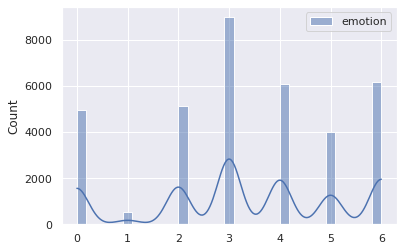

In [37]:
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

In [38]:
#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [39]:
train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [40]:
#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [48]:
#Training the model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=100,verbose=2,callbacks=[es],validation_split=0,validation_data=(val_X,val_Y),shuffle=True)

Epoch 1/100
449/449 - 12s - loss: 0.8917 - accuracy: 0.6671 - val_loss: 1.1049 - val_accuracy: 0.5949
Epoch 2/100
449/449 - 12s - loss: 0.8880 - accuracy: 0.6671 - val_loss: 1.1137 - val_accuracy: 0.5938
Epoch 3/100
449/449 - 12s - loss: 0.8768 - accuracy: 0.6759 - val_loss: 1.1365 - val_accuracy: 0.5868
Epoch 4/100
449/449 - 12s - loss: 0.8772 - accuracy: 0.6722 - val_loss: 1.1901 - val_accuracy: 0.5617
Epoch 5/100
449/449 - 12s - loss: 0.8767 - accuracy: 0.6734 - val_loss: 1.1194 - val_accuracy: 0.5876
Epoch 6/100
449/449 - 12s - loss: 0.8608 - accuracy: 0.6792 - val_loss: 1.1062 - val_accuracy: 0.5879
Epoch 7/100
449/449 - 12s - loss: 0.8635 - accuracy: 0.6789 - val_loss: 1.1081 - val_accuracy: 0.5949
Epoch 8/100
449/449 - 12s - loss: 0.8541 - accuracy: 0.6797 - val_loss: 1.1172 - val_accuracy: 0.5834
Epoch 9/100
449/449 - 12s - loss: 0.8555 - accuracy: 0.6826 - val_loss: 1.1274 - val_accuracy: 0.5840
Epoch 10/100
449/449 - 12s - loss: 0.8433 - accuracy: 0.6864 - val_loss: 1.1134 - 

In [49]:
loss_and_metrics = model.evaluate(test_X,test_Y)
print(loss_and_metrics)

113/113 [==============================] - 1s 6ms/step - loss: 1.0974 - accuracy: 0.5999
[1.0974410772323608, 0.5998885631561279]


In [50]:
#Evaluate the test performance 
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.5999


In [51]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
